# Importing necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd

pd.set_option('display.max_columns', None)

directory = '/content/gdrive/My Drive/SentimentAnalysis/IMDB_SentimentAnalysis/'


df = pd.read_csv(os.path.join(directory, 'IMDB Dataset.csv'))


In [ ]:
df.shape

(50000, 2)

In [ ]:
#df = df.sample(5000)

# Cleaning & Visualising Data

In [ ]:
df['target']=df['sentiment'].map({'negative':0,'positive':1})

<Axes: >

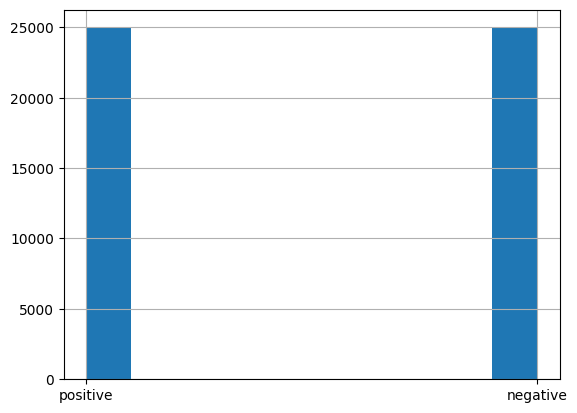

In [ ]:
df.sentiment.hist()

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

len(stop)

211

In [ ]:
def   clean_text(raw_text):
    text_without_html = BeautifulSoup(raw_text, "html.parser").get_text()
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s]", "", text_without_html)

    return cleaned_text
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+|\S+\.\S+')
    return re.sub(url_pattern, '', text)
def remove_stopwords(text):
    final_text=[]
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
def denoise_text(text) :
    text = text.lower()
    text = clean_text(text)
    text = remove_urls(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
df['text']=df['review'].apply(denoise_text)

<ipython-input-11-c2ca1c43a0d8>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_without_html = BeautifulSoup(raw_text, "html.parser").get_text()


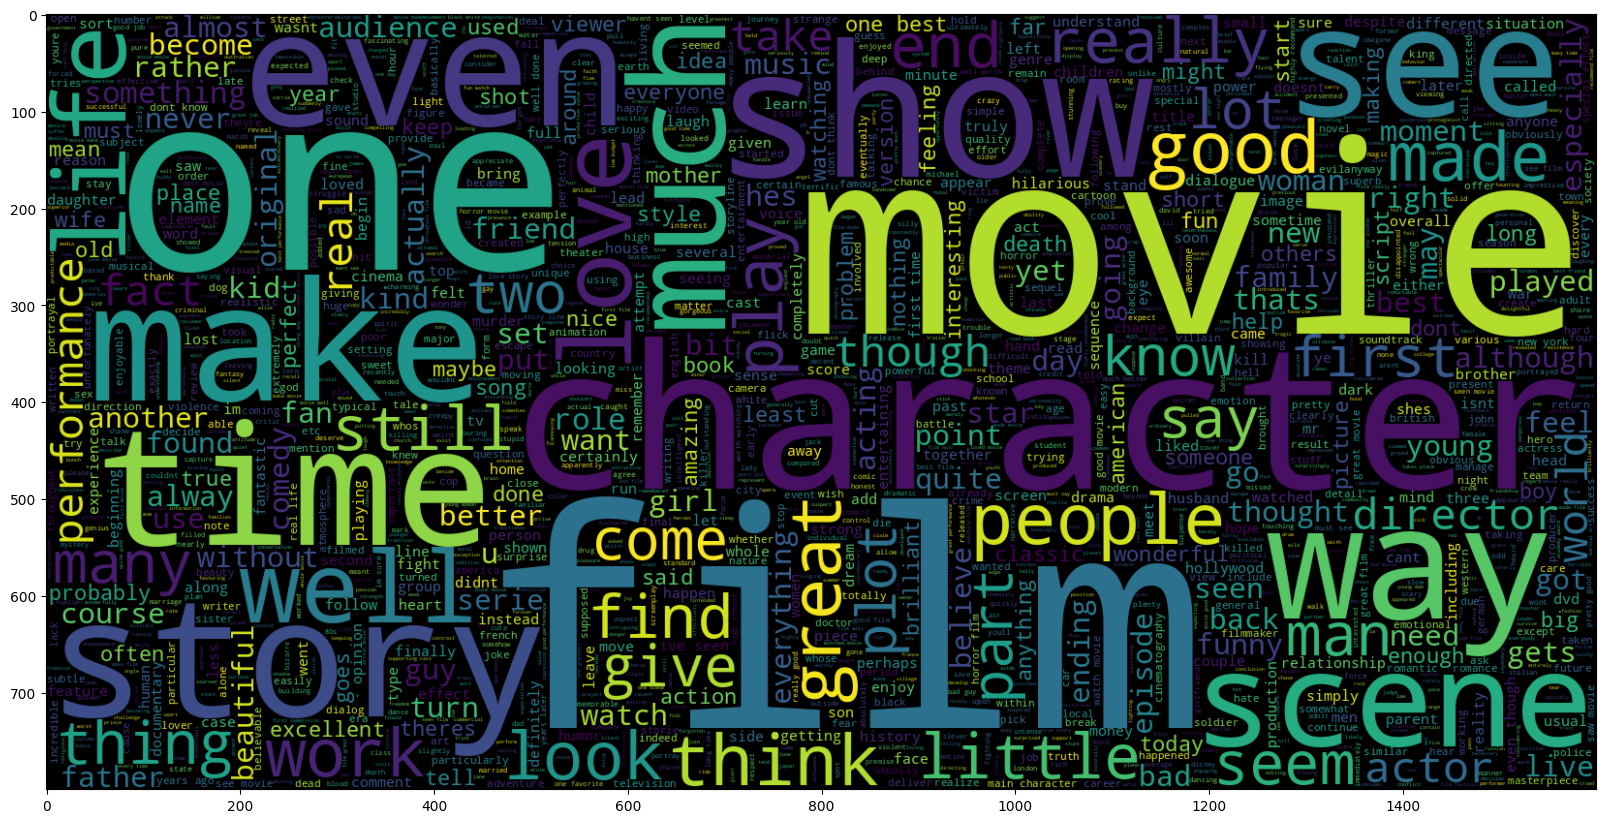

In [ ]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=2000, width= 1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.target==1].text))
plt.imshow(wc, interpolation='bilinear')

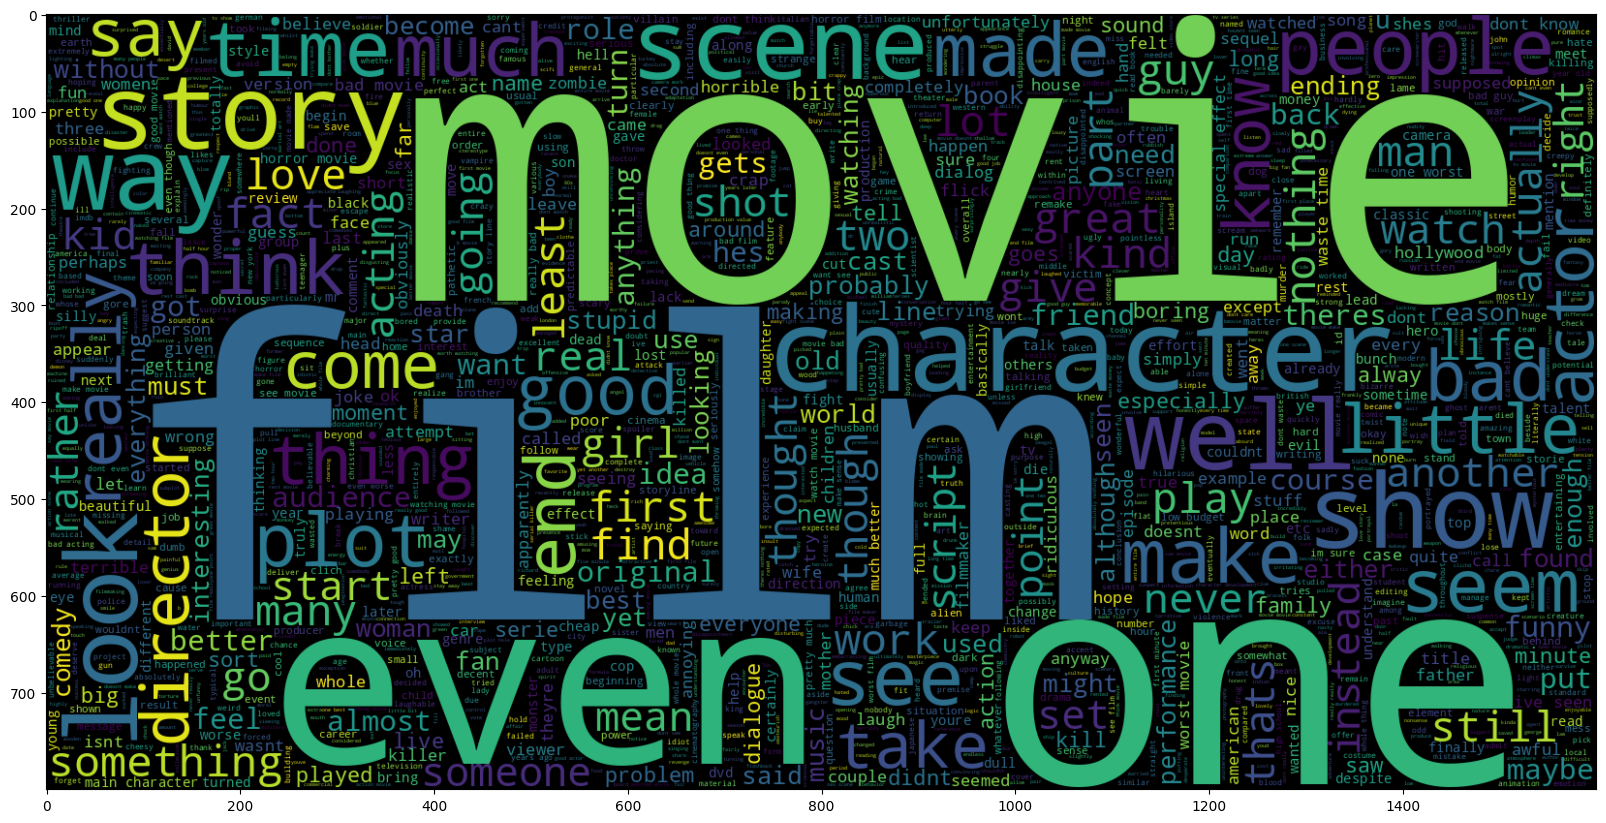

In [ ]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=2000, width= 1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.target==0].text))
plt.imshow(wc, interpolation='bilinear')

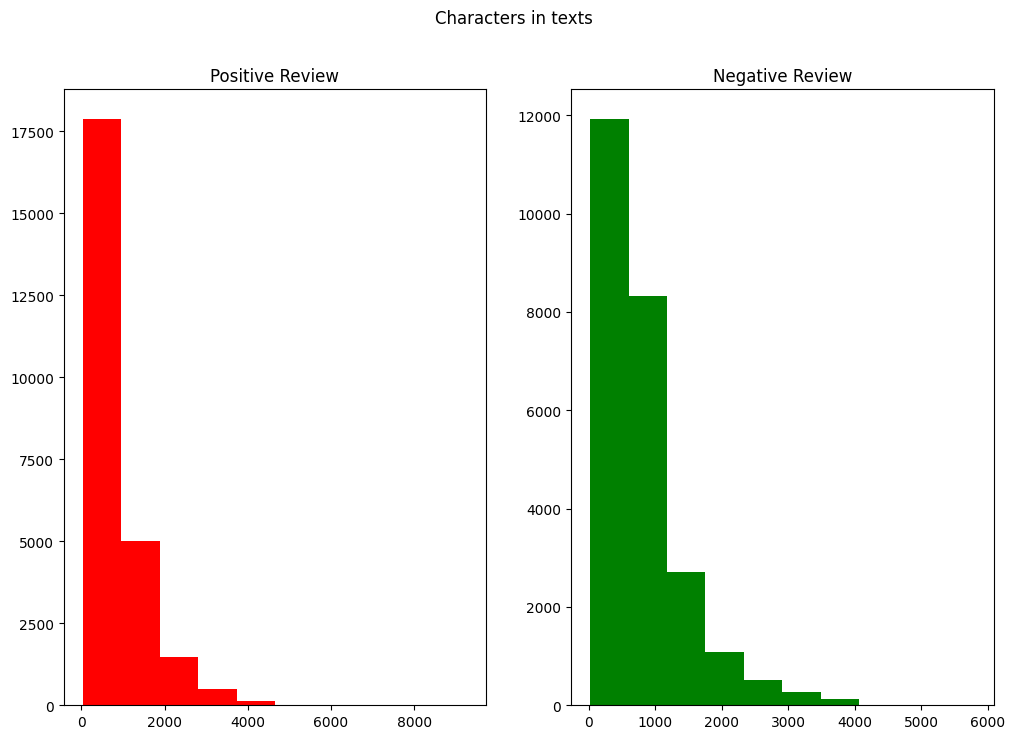

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['target']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Positive Review')
text_len=df[df['target']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Negative Review')
fig.suptitle('Characters in texts')
plt.show()

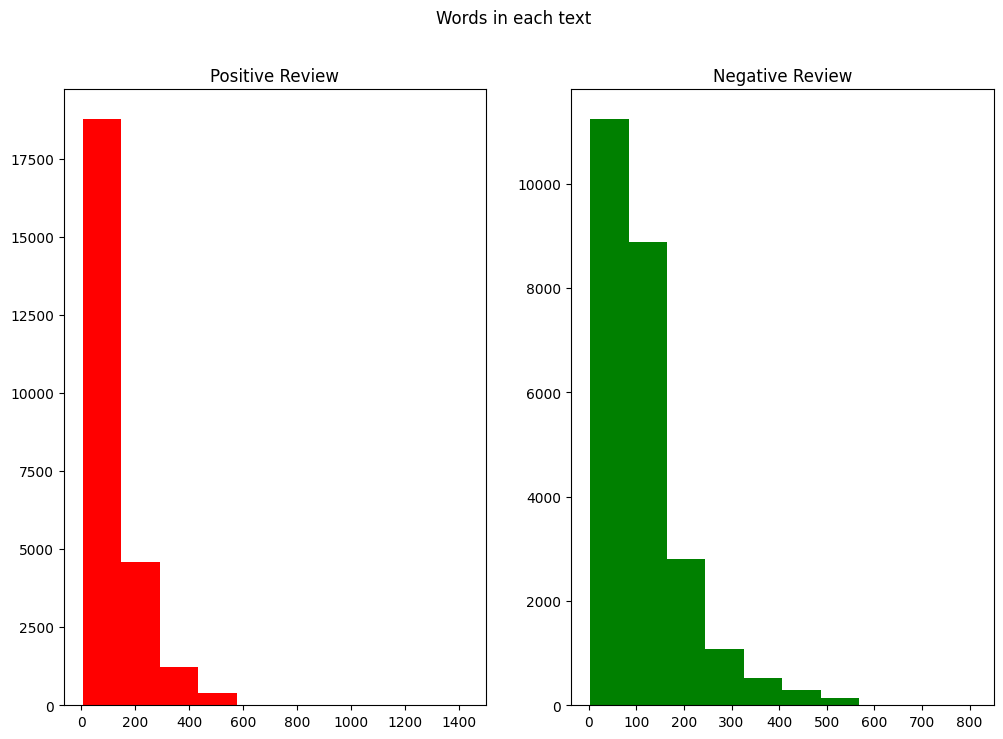

In [ ]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(12,8))
word_len=df[df['target']==1]['text'].str.split().map(lambda x:len(x))
ax1.hist(word_len,color='red')
ax1.set_title('Positive Review')
word_len=df[df['target']==0]['text'].str.split().map(lambda x:len(x))
ax2.hist(word_len,color='green')
ax2.set_title('Negative Review')
fig.suptitle('Words in each text')
plt.show()

<ipython-input-17-9db861a77cbf>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
<ipython-input-17-9db861a77cbf>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')


Text(0.5, 0.98, 'Average word length in each text')

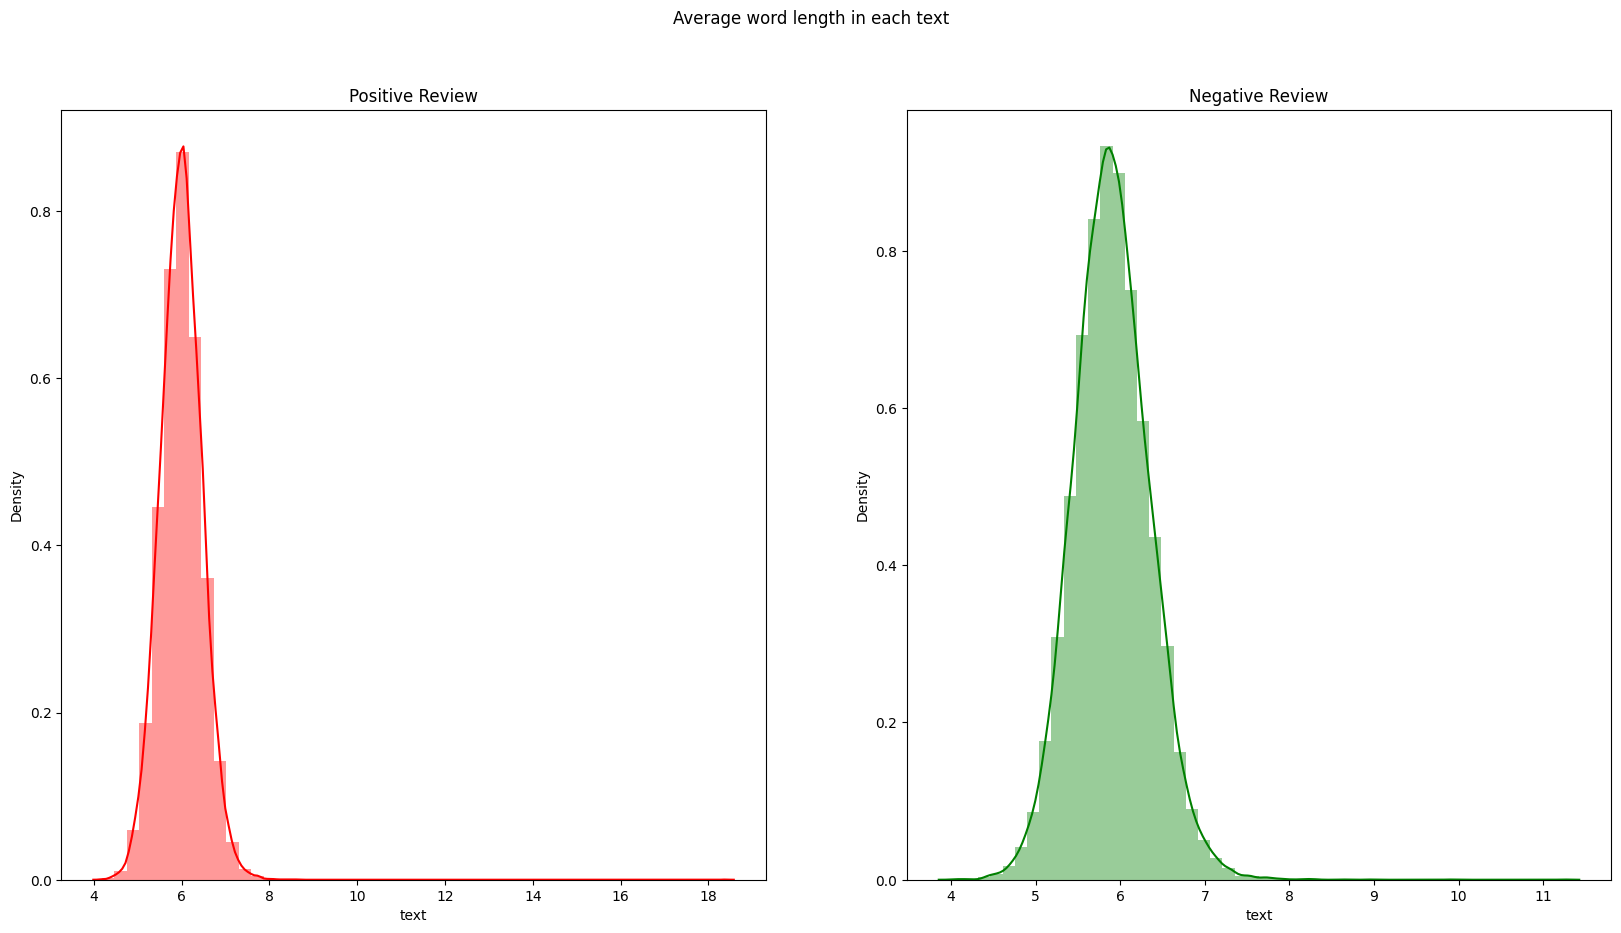

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Positive Review')
word=df[df['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Negative Review')
fig.suptitle('Average word length in each text')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

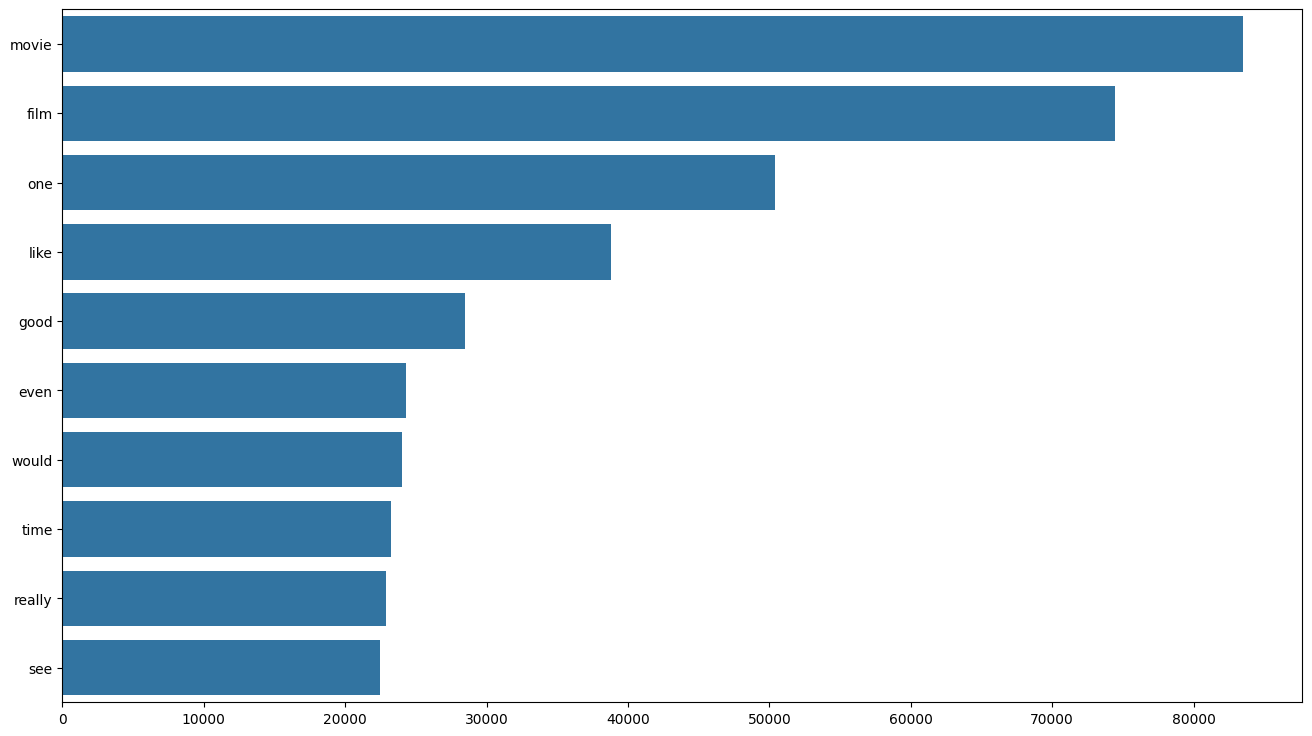

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

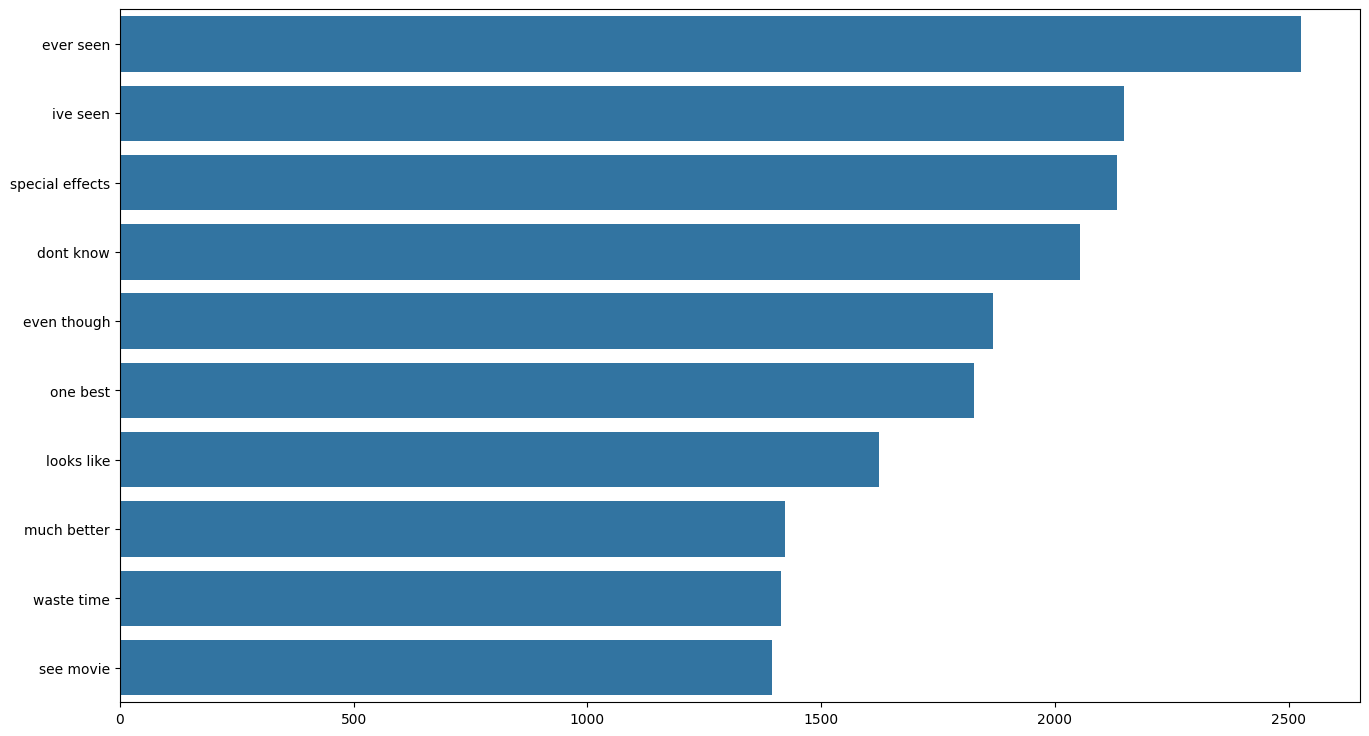

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

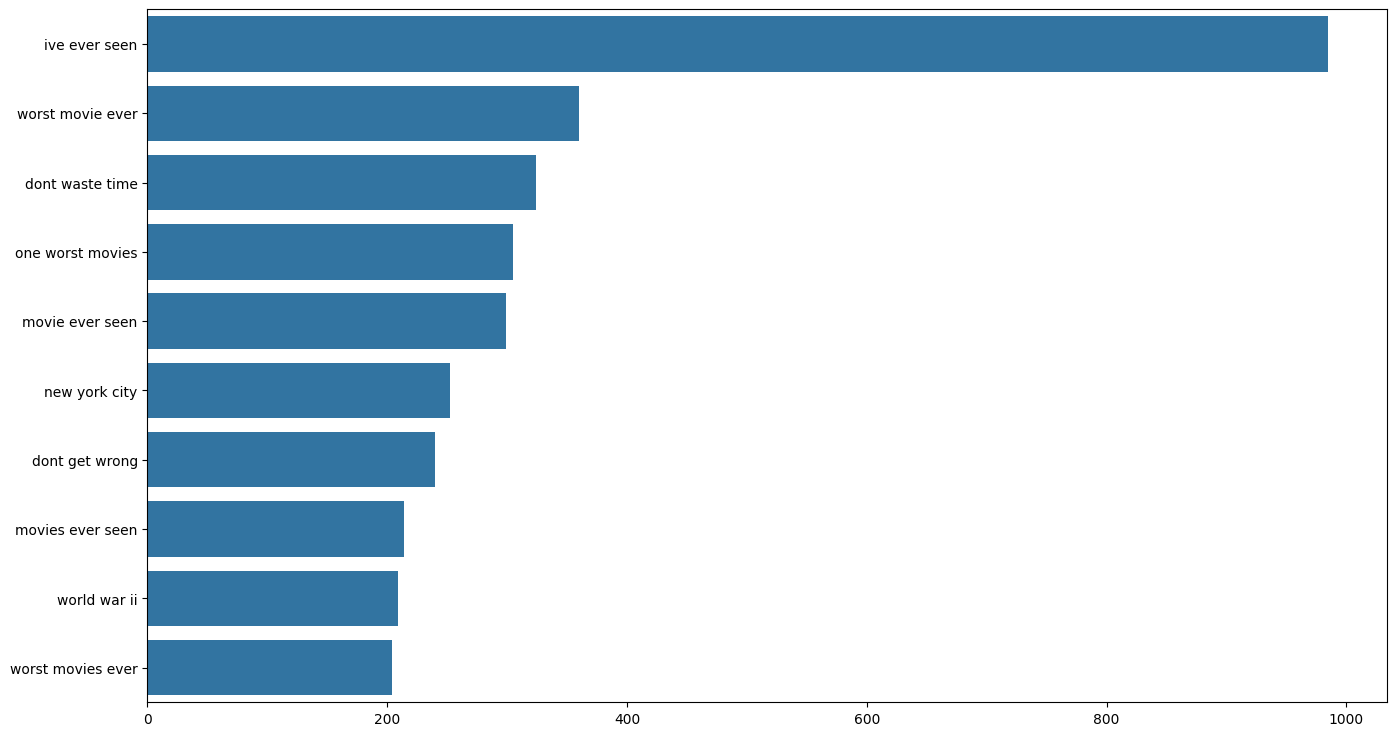

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

# Data Prepration

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 83510,
 'film': 74463,
 'one': 50367,
 'like': 38826,
 'good': 28483,
 'even': 24281,
 'would': 24001,
 'time': 23267,
 'really': 22894,
 'see': 22432}

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.target,test_size=0.95,random_state = 0)

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-01-18 16:33:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-18 16:33:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-18 16:33:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
EMBEDDING_FILE = '/content/glove.6B.100d.txt'

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

# Modelling

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
batch_size = 256
epochs = 15
embed_size = 100

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/15
92/92 [==============================] - 820s 9s/step - loss: 0.5041 - accuracy: 0.7599 - val_loss: 0.4871 - val_accuracy: 0.7707
Epoch 2/15
92/92 [==============================] - 804s 9s/step - loss: 0.4266 - accuracy: 0.8059 - val_loss: 0.4369 - val_accuracy: 0.8120
Epoch 3/15
92/92 [==============================] - 798s 9s/step - loss: 0.3835 - accuracy: 0.8309 - val_loss: 0.3946 - val_accuracy: 0.8290
Epoch 4/15
92/92 [==============================] - 811s 9s/step - loss: 0.3650 - accuracy: 0.8395 - val_loss: 0.3616 - val_accuracy: 0.8480
Epoch 5/15
92/92 [==============================] - 797s 9s/step - loss: 0.3474 - accuracy: 0.8487 - val_loss: 0.3703 - val_accuracy: 0.8330
Epoch 6/15
92/92 [==============================] - 797s 9s/step - loss: 0.3454 - accuracy: 0.8503 - val_loss: 0.3419 - val_accuracy: 0.8567
Epoch 7/15
66/92 [====================>.........] - ETA: 3:47 - loss: 0.3300 - accuracy: 0.8590

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

In [ ]:
acc = str(model.evaluate(X_test,y_test)[1]*100)

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Evaluation

In [ ]:
pred = model.predict(X_test)
pred[:5]

In [ ]:
pred = (pred > 0.5).astype(int)

In [ ]:
pred[:5]

In [ ]:
print(classification_report(y_test, pred, target_names = ['Negative','Positive']))

In [ ]:
cm = confusion_matrix(y_test,pred)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['Negative','Positive'] , columns =['Negative','Positive'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Negative','Positive'] , yticklabels = ['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Prediction

In [ ]:
inp_text = "What the hell management is doing?"
inp_text = denoise_text(inp_text)
tokenized_test = tokenizer.texts_to_sequences([inp_text])
inp_text = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

model.predict(inp_text)

# Exporting Models

In [ ]:
import pickle

In [ ]:
from transformers import AutoTokenizer
from google.colab import drive
drive.mount('/content/gdrive')
dir_path = f'/content/gdrive/MyDrive/SentimentAnalysis/Models/{acc}'.replace(".","-")
os.makedirs(dir_path, exist_ok=True)

In [ ]:
import json
import pickle

# Save the tokenizer
with open(f'{dir_path}/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Save the model
with open(f'{dir_path}/model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save the tokenizer configuration as JSON
tokenizer_config = tokenizer.get_config()
with open(f'{dir_path}/tokenizer_config.json', 'w') as json_file:
    json.dump(tokenizer_config, json_file)

In [ ]:
import joblib
import json

# Save the tokenizer
joblib.dump(tokenizer, f'{dir_path}/tokenizer_joblib.joblib')

# Save the model
joblib.dump(model, f'{dir_path}/model_joblib.joblib')

# Save the tokenizer configuration as JSON
tokenizer_config = tokenizer.get_config()
with open(f'{dir_path}/tokenizer_config_joblib.json', 'w') as json_file:
    json.dump(tokenizer_config, json_file)

model.save(f'{dir_path}/model_dir.h5')
